In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem.porter import *
import re
from sklearn.feature_extraction import text

# for visualisation
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# tensor packages
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Concatenate, Input
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

# hide warnings
import warnings 
warnings.filterwarnings("ignore")

In [64]:
training_data = pd.read_csv('Data/train.csv', index_col = [0])

In [65]:
test_data = pd.read_csv('Data/test.csv', index_col = [0])

Preprocessing

In [66]:
training_data.product_description = training_data.product_description.fillna('')
test_data.product_description = test_data.product_description.fillna('')

In [67]:
# stop word removal
stemmer = PorterStemmer()
sw=[]
ML_STOP_WORDS = ['http','www','img','border','color','style','padding','table','font','inch','width','height']
ML_STOP_WORDS += list(text.ENGLISH_STOP_WORDS)
for stw in ML_STOP_WORDS:
    sw.append("z"+str(stw))
ML_STOP_WORDS += sw
for i in range(len(ML_STOP_WORDS)):
    ML_STOP_WORDS[i]=stemmer.stem(ML_STOP_WORDS[i])

In [68]:
# declarations
def ML_TEXT_CLEAN(f2,f3):
    if len(f2)<3:
        f2="feature2null"
    if len(f3)<3:
        f3="feature3null"
    tx = BeautifulSoup(f3)
    tx1 = [x.extract() for x in tx.findAll('script')]
    tx = tx.get_text(" ").strip()
    #s = (" ").join(["z"+ str(z) for z in f2.split(" ")]) + " " + tx
    s = (" ").join([str(z) for z in f2.split(" ")]) + " " + tx
    s = re.sub("[^a-zA-Z0-9]"," ", s)
    s = re.sub("[0-9]{1,3}px"," ", s)
    s = re.sub(" [0-9]{1,6} |000"," ", s)
    s = (" ").join([stemmer.stem(z) for z in s.split(" ") if len(z)>2])
    s = s.lower()
    return s

In [69]:
# Cleaning training data
s_data = []
for i in range(len(training_data.id)):
    s = ML_TEXT_CLEAN(training_data.product_title[i], training_data.product_description[i])
    s_data.append((training_data["query"][i], s, str(training_data["median_relevance"][i])))

In [70]:
# Cleaning test data
t_data = []
for i in range(len(test_data.id)):
    s = ML_TEXT_CLEAN(test_data.product_title[i], test_data.product_description[i])
    t_data.append((test_data["query"][i], s, str(test_data["median_relevance"][i])))

In [71]:
# Converting into dataframe
training_df = pd.DataFrame(s_data)
test_df = pd.DataFrame(t_data)

In [72]:
# Shape of data
print('training data shape : ', training_df.shape) # (7618, 3)
print('test data shape : ', test_df.shape) # (2540, 3)

training data shape :  (7618, 3)
test data shape :  (2540, 3)




---



Neural Network

In [131]:
# define the number of classes
num_classes = 4

In [132]:
# define the input shape
max_len = 600
input_shape = (max_len,)

# define the NN model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=input_shape))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [133]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [134]:
# Create input data
train_data = training_df[[0,1]]
test_data = test_df[[0,1]] 

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data[0].values + train_data[1].values)

In [135]:
# convert the input text to sequences
x_train1 = tokenizer.texts_to_sequences(train_data[0].values)
x_test1 = tokenizer.texts_to_sequences(test_data[0].values)

x_train2 = tokenizer.texts_to_sequences(train_data[1].values)
x_test2 = tokenizer.texts_to_sequences(test_data[1].values)

In [136]:
# Pad the sequences to a fixed length
max_sequence_length = 300
x_train1 = pad_sequences(x_train1, maxlen=max_sequence_length)
x_train2 = pad_sequences(x_train2, maxlen=max_sequence_length)
x_test1 = pad_sequences(x_test1, maxlen=max_sequence_length)
x_test2 = pad_sequences(x_test2, maxlen=max_sequence_length)

In [137]:
# concatenate the two input matrices
x_train = np.concatenate((x_train1, x_train2), axis=1)
x_test = np.concatenate((x_test1, x_test2), axis=1)

In [138]:
# Initialize a label encoder
label_encoder = LabelEncoder()

# Fit the encoder to the class labels and transform the labels to integers
y_train_encoded = label_encoder.fit_transform(training_df[2])
y_test_encoded = label_encoder.fit_transform(test_df[2])

# Convert the output data to one-hot encoded format
y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes=4)

In [143]:
# train the model
history = model.fit(x_train, y_train,
          batch_size=32,
          epochs=100,
          validation_data=(x_test, y_test))

Epoch 1/100
239/239 [==============================] - 2s 10ms/step - loss: 1.0866 - accuracy: 0.6045 - val_loss: 1.0659 - val_accuracy: 0.6165
Epoch 2/100
239/239 [==============================] - 2s 7ms/step - loss: 1.0866 - accuracy: 0.6045 - val_loss: 1.0658 - val_accuracy: 0.6165
Epoch 3/100
239/239 [==============================] - 2s 7ms/step - loss: 1.1271 - accuracy: 0.6044 - val_loss: 1.0659 - val_accuracy: 0.6165
Epoch 4/100
239/239 [==============================] - 2s 9ms/step - loss: 1.0866 - accuracy: 0.6045 - val_loss: 1.0660 - val_accuracy: 0.6165
Epoch 5/100
239/239 [==============================] - 2s 8ms/step - loss: 1.0865 - accuracy: 0.6045 - val_loss: 1.0660 - val_accuracy: 0.6165
Epoch 6/100
239/239 [==============================] - 2s 7ms/step - loss: 1.0865 - accuracy: 0.6045 - val_loss: 1.0661 - val_accuracy: 0.6165
Epoch 7/100
239/239 [==============================] - 2s 7ms/step - loss: 1.1062 - accuracy: 0.6045 - val_loss: 1.0661 - val_accuracy: 0.616

In [144]:
# Model loss graph
fig = make_subplots(rows=1, cols=2, subplot_titles=('Training Loss', 'Validation Loss'))

fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss'])+1)), y=history.history['loss'], name='Training'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss'])+1)), y=history.history['val_loss'], name='Validation'), row=1, col=2)

fig.update_layout(height=400, width=800, title_text="Model Loss")
fig.show()

In [145]:
# Model Accuracy graph
fig = make_subplots(rows=1, cols=2, subplot_titles=('Training Accuracy', 'Validation Accuracy'))

fig.add_trace(go.Scatter(x=list(range(1, len(history.history['accuracy'])+1)), y=history.history['accuracy'], name='Training'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_accuracy'])+1)), y=history.history['val_accuracy'], name='Validation'), row=1, col=2)

fig.update_layout(height=400, width=800, title_text="Model Accuracy")
fig.show()

In [147]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(x_test, y_test, batch_size=150)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

17/17 [==============================] - 0s 6ms/step - loss: 1.0659 - accuracy: 0.6165
Test loss: 1.0658626556396484
Test accuracy: 0.6165354251861572


In [149]:
# predict target values on the test data
preds = model.predict(x_test)

# convert the predicted values to the original labels
preds = np.argmax(preds, axis=1)

# convert the test labels to the original labels
y_test = np.argmax(y_test, axis=1)

# print the classification report
print(classification_report(y_test, preds))

80/80 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       186
           1       0.00      0.00      0.00       337
           2       0.00      0.00      0.00       451
           3       0.62      1.00      0.76      1566

    accuracy                           0.62      2540
   macro avg       0.15      0.25      0.19      2540
weighted avg       0.38      0.62      0.47      2540



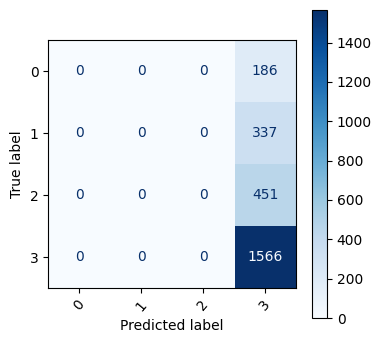

In [150]:
# plot the confusion matrix
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
disp.figure_.set_size_inches(4,4)
plt.xticks(rotation=50)
plt.show()

**MLP**

In [151]:
from sklearn.neural_network import MLPRegressor

In [152]:
nn = MLPRegressor(hidden_layer_sizes=(100,100,100,100,100,100,100,100,8), random_state=1, max_iter=500, activation='tanh')
nn.fit(x_train, y_train)

MLPRegressor(activation='tanh',
             hidden_layer_sizes=(100, 100, 100, 100, 100, 100, 100, 100, 8),
             max_iter=500, random_state=1)

In [178]:
mlp_y_pred_probs = nn.predict(x_test)
mlp_y_pred_labels = np.argmax(mlp_y_pred_probs, axis=1)

In [186]:
print(classification_report(y_test, mlp_y_pred_labels))

              precision    recall  f1-score   support

           0       0.12      0.05      0.07       186
           1       0.15      0.09      0.12       337
           2       0.21      0.06      0.09       451
           3       0.63      0.86      0.73      1566

    accuracy                           0.56      2540
   macro avg       0.28      0.26      0.25      2540
weighted avg       0.45      0.56      0.48      2540



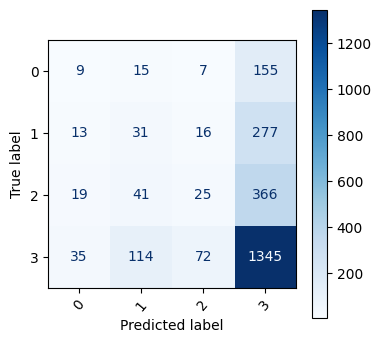

In [187]:
# plot the confusion matrix
cm = confusion_matrix(y_test, mlp_y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
disp.figure_.set_size_inches(4,4)
plt.xticks(rotation=50)
plt.show()

**ExtraTrees**

In [188]:
from sklearn.ensemble import ExtraTreesRegressor as ET

In [189]:
et = ET(n_estimators=250, min_samples_split=10)
et.fit(x_train, y_train)

ExtraTreesRegressor(min_samples_split=10, n_estimators=250)

In [193]:
et_pred_test = et.predict(x_test)
et_pred_test = np.argmax(et_pred_test, axis=1)

In [194]:
print(classification_report(y_test, et_pred_test))

              precision    recall  f1-score   support

           0       0.48      0.11      0.18       186
           1       0.34      0.11      0.16       337
           2       0.35      0.06      0.10       451
           3       0.65      0.96      0.77      1566

    accuracy                           0.62      2540
   macro avg       0.45      0.31      0.30      2540
weighted avg       0.54      0.62      0.53      2540



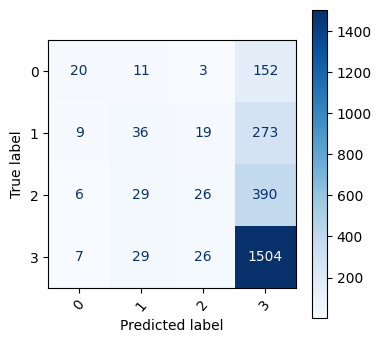

In [195]:
# plot the confusion matrix
cm = confusion_matrix(y_test, et_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
disp.figure_.set_size_inches(4,4)
plt.xticks(rotation=50)
plt.show()

**ElasticNet**

In [233]:
from sklearn.linear_model import ElasticNet

In [247]:
mlp_y_pred_labels_temp = mlp_y_pred_labels.reshape(2540)

In [249]:
# Blending
ensemble = ElasticNet(alpha=0.01, l1_ratio=0.5, fit_intercept=False)
ensemble.fit(np.vstack((et_pred_test, mlp_y_pred_labels_temp)).T, y_test)

ElasticNet(alpha=0.01, fit_intercept=False)

In [286]:
ensemble_pred = ensemble.predict(np.vstack((et_pred_test, mlp_y_pred_labels_temp)).T)

In [294]:
# define a custom function to distribute result into 4 classes
def distribute(numbers):
    min_num = min(numbers)
    max_num = max(numbers)
    diff = (max_num - min_num) / 4
    labels = []
    for n in numbers:
        if n < min_num + diff:
            labels.append(0)
        elif n < min_num + 2 * diff:
            labels.append(1)
        elif n < min_num + 3 * diff:
            labels.append(2)
        else:
            labels.append(3)
    return labels

labels = distribute(ensemble_pred)


In [296]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3]), array([  42,  105,   74, 2319], dtype=int64))

In [297]:
print(classification_report(y_test, labels))

              precision    recall  f1-score   support

           0       0.48      0.11      0.18       186
           1       0.34      0.11      0.16       337
           2       0.35      0.06      0.10       451
           3       0.65      0.96      0.77      1566

    accuracy                           0.62      2540
   macro avg       0.45      0.31      0.30      2540
weighted avg       0.54      0.62      0.53      2540



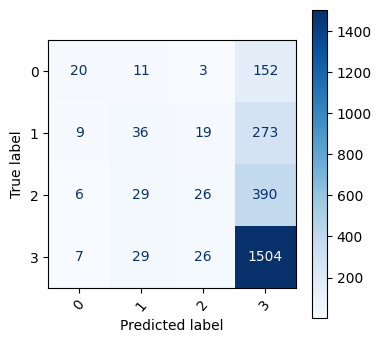

In [298]:
# plot the confusion matrix
ensemble_cm = confusion_matrix(y_test, labels)
ensemble_disp = ConfusionMatrixDisplay(confusion_matrix=ensemble_cm)

ensemble_disp.plot(cmap=plt.cm.Blues)
ensemble_disp.figure_.set_size_inches(4,4)
plt.xticks(rotation=50)
plt.show()